Populating the interactive namespace from numpy and matplotlib
tensor(0.1383, device='cuda:0', grad_fn=<DivBackward0>)
0
costs [tensor(-0.9623, device='cuda:0', grad_fn=<NegBackward>), tensor(-0.8857, device='cuda:0', grad_fn=<NegBackward>), tensor(-0.8669, device='cuda:0', grad_fn=<NegBackward>), tensor(-0.8621, device='cuda:0', grad_fn=<NegBackward>), tensor(-0.8264, device='cuda:0', grad_fn=<NegBackward>), tensor(-0.3924, device='cuda:0', grad_fn=<NegBackward>), tensor(-0.1032, device='cuda:0', grad_fn=<NegBackward>), tensor(-0.0220, device='cuda:0', grad_fn=<NegBackward>)]
entr tensor(0.0220, device='cuda:0', grad_fn=<MulBackward0>)
inf tensor(0.1589, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.0533, device='cuda:0', grad_fn=<DivBackward0>)
100
costs [tensor(-1.6694, device='cuda:0', grad_fn=<NegBackward>), tensor(-2.0602, device='cuda:0', grad_fn=<NegBackward>), tensor(-2.2390, device='cuda:0', grad_fn=<NegBackward>), tensor(-2.2443, device='cuda:0', grad_fn=<NegBackward>), 

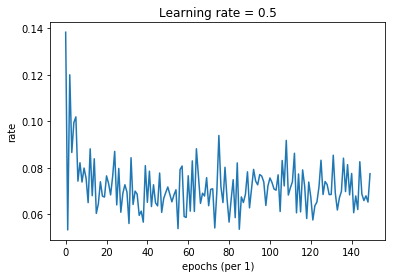

In [12]:
##### import numpy as np
import matplotlib.pyplot as plt
%pylab inline
delta=5
def gausin_distance(x,y,delta=delta):
    H= torch.norm(x-y).cuda()
    distance = torch.exp(-H/2/(delta**2)).cuda()
    
    return distance
def gram_matrix(data,kernel=gausin_distance):
    #num=data.shape[0]
    #matrix=torch.zeros((num,num)).cuda()
    #for i in range (0,num):
    #   for j in range (0,num):
    #        matrix[i][j]=kernel(data[i],data[j])
    num=data.shape[0]
    datav3=torch.mm(data,torch.transpose(data, 0, 1).cuda()).cuda()
    datav1=torch.diag(datav3,0).cuda()
    #print(datav1.shape)
    #matrix=torch.sqrt(datav1+datav2-2*datav3)
    buf1=((-2)*datav3+datav1).cuda()
    buf2=torch.transpose(buf1, 0, 1).cuda()
    buf3=(buf2+datav1).cuda()
    #print(buf3)
    matrix = torch.exp(-buf3/2/(delta**2)).cuda()
    return matrix
def emerinal_hsic(X,Y):
    num=X.shape[0]
    #print(num)
    
    
    
    Kx=gram_matrix(X)
    
    Ky=gram_matrix(Y)
    
    H = torch.eye(num).cuda() - torch.ones((num,num), dtype = torch.float32).cuda() / num
    #print(H)
    hsic=1/(num-1)*torch.trace(torch.mm(torch.mm(torch.mm(Kx,H).cuda(),Ky).cuda(),H).cuda()).cuda()
    
    return hsic
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import torchvision.datasets
from PIL import Image
batch_size=256
class MyMNIST(torchvision.datasets.MNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None,download=False):
        
        super(MyMNIST,self).__init__(root, train, transform, target_transform,download)
        #print(self.data)
    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])
        #print(target) 
        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)
            
        else:
            target=torch.as_tensor(target)
            target = F.one_hot(target,num_classes=10).cuda()

        return img, target
mnist_data=torchvision.datasets.MNIST(root='./MNIST/', train=True, transform=transforms.ToTensor(), target_transform=None, download=False)
data_loader = torch.utils.data.DataLoader(mnist_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)
#D_in, H1,H2,H3,H4,H5,H6,H7, D_out = 784, 64,32,16,8,4,2,1,10
layer_num=[784,200,200,200,200,64,16,4,1]
costs=[]
dtype=torch.float
continue_flag=0
PATH='./checkpoint_multilayer_nbp'
w=[]
z=[]
b=[]
rate_list=[]
if continue_flag:
    
    checkpoint = torch.load(PATH)
    
    w=checkpoint['w']
    b=checkpoint['b']

else:
    for i in range(len(layer_num)-1):
    
        w.append(torch.randn(layer_num[i],layer_num[i+1], dtype=dtype, requires_grad=True,device="cuda"))
        b.append(torch.randn(layer_num[i+1],dtype=dtype, requires_grad=True,device="cuda"))
epoches=50
lamda=200
learning_rate=0.5
data_tsne_label=[]
data_tsne_rp1=[]
data_tsne_rp2=[]
for i in range(epoches): 
    for i_batch, (img,target) in enumerate(data_loader):
        costs=[]
        z=[]
        img=img.reshape(-1,layer_num[0]).cuda()
        
        target=torch.as_tensor(target).cuda()
        num=target.shape[0]
        #print(num)
        target=target.reshape(num,1).cuda()
        #target = F.one_hot(target,num_classes=10).cuda()
        target=torch.zeros((num,10)).cuda().scatter_(1,target,1).cuda()
        
        target=torch.as_tensor(target,dtype=dtype).cuda()
        
        z.append(torch.tanh(torch.mm(img,w[0]).cuda()+b[0]).cuda())
        for cnt in range(len(w)-1):
            
            z.append(torch.tanh(torch.mm(z[cnt],w[cnt+1]).cuda()+b[cnt+1].cuda()).cuda())
            
        grad_listw=[]
        grad_listb=[]
        lock=[0,1,2,3,4,5]
        for cnt in range(len(z)-1):
            
            entropy=emerinal_hsic(z[cnt],img)
                
            
            information=lamda*emerinal_hsic(z[cnt],target)
            cost=-entropy
            #-information
            costs.append(cost)
            #0.1*(entropy/information)
        #print(cost1)
            cost.backward(retain_graph=True)
            #print('!')
        #print(w1.cuda().grad)
            with torch.no_grad():
                bufw=torch.zeros((w[cnt].shape)).cuda()
                bufb=torch.zeros((b[cnt].shape)).cuda()
                #print(buf.shape)
                bufw.copy_(w[cnt].grad)
                bufb.copy_(b[cnt].grad)
                grad_listw.append(bufw)
                grad_listb.append(bufb)
                #print(cnt,torch.norm(w[cnt].grad),torch.norm(b[cnt].grad))
            #w2 -= learning_rate * w2.grad

            # Manually zero the gradients after updating weights
                w[cnt].grad.zero_()
                b[cnt].grad.zero_()
                
                #print(cnt,torch.norm(buf))
            #w2.grad.zero_()
        entropy=emerinal_hsic(z[-1],img)
        information=lamda*emerinal_hsic(z[-1],target)
        rate=emerinal_hsic(z[-1],img)/information
        cost=-entropy
        #-information
        costs.append(cost)
        #+rate
        #+0.1*(entropy/information)
        cost.backward()
        with torch.no_grad():
            #w1 -= learning_rate * w1.grad
            #print('grad2',torch.norm(w2.grad))
            w[-1] -= learning_rate * w[-1].grad
            b[-1] -= learning_rate * b[-1].grad
            
            for cnt in range(len(w)-1):
                w[cnt] -= learning_rate * grad_listw[cnt]
                b[cnt] -= learning_rate * grad_listb[cnt]
        # Manually zero the gradients after updating weights
            w[-1].grad.zero_()
            b[-1].grad.zero_()
        #    data_tsne_rp2.append(z2.cpu().data.numpy())
        #    data_tsne_rp1.append(z1.cpu().data.numpy())
        #    data_tsne_label.append(target.argmax(dim=1, keepdim=True).cpu().data.numpy())
        

        if i_batch %100 ==0:
            print(rate)
            rate_list.append(rate)
            print(i_batch)
            print('costs',costs)
            print('entr',entropy)
            print('inf',information)
            data_tsne_label.append(target.argmax(dim=1, keepdim=True).cpu().data.numpy())
            torch.save({
            'w': w,
            'z': z,
            'b': b,
            'data_tsne_label':target.argmax(dim=1, keepdim=True).cpu().data.numpy()
            ,'costs':costs
            #'data_tsne_rp2':data_tsne_rp2,
            #'data_tsne_rp1':data_tsne_rp1
                
            }, PATH)
            
            data_tsne_label=[]
            #data_tsne_rp1=[]
            #data_tsne_rp2=[]

            #for j,zz in enumerate(z2):
                #print(j,zz)
                #print(j,target[j])
            
plt.plot(rate_list)
plt.ylabel('rate')
plt.xlabel('epochs (per 1)')
plt.title("Learning rate = " + str(learning_rate))
plt.show()

In [18]:
##### import torch
import matplotlib.pyplot as plt
from matplotlib import cm
%pylab inline
import numpy as np
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('Please install sklearn for layer visualization')
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    print(len(labels))
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

plt.ion()
PATH='./checkpoint_multilayer_nbp'
checkpoint = torch.load(PATH)
data_tsne_label=np.array(checkpoint['data_tsne_label'])
data_tsne_rp=np.array(checkpoint['z'][-1].cpu().data.numpy())
print(data_tsne_rp.shape)
print(data_tsne_rp[:50,:],data_tsne_label[:50])
for j in range(500):
    if data_tsne_label[j]==2:
        
        print(data_tsne_rp[j,:])
    
#print()
data_tsne_label=data_tsne_label.reshape((-1))
#print(data_tsne_label)
#data_tsne=np.array(data_tsne[:][])
if HAS_SK:
    # Visualization of trained flatten layer (T-SNE)
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=500)
    plot_only = 255
    low_dim_embs = tsne.fit_transform(data_tsne_rp[:plot_only,:])
    labels = data_tsne_label[:plot_only]
    plot_with_labels(low_dim_embs, labels)
plt.ioff()

Populating the interactive namespace from numpy and matplotlib
(256, 1)
[[ 0.46471953]
 [-0.82766646]
 [ 0.9702898 ]
 [-0.9619364 ]
 [ 0.934251  ]
 [ 0.99547   ]
 [ 0.72801495]
 [ 0.9924328 ]
 [-0.8758619 ]
 [ 0.9985784 ]
 [-0.955257  ]
 [ 0.9988217 ]
 [ 0.47639382]
 [ 0.96668047]
 [-0.30634132]
 [-0.95631194]
 [ 0.03375993]
 [ 0.99917275]
 [ 0.9814563 ]
 [ 0.241264  ]
 [ 0.96755624]
 [ 0.99953455]
 [-0.32395768]
 [ 0.3800482 ]
 [ 0.99020684]
 [ 0.9755282 ]
 [ 0.5734639 ]
 [ 0.32575873]
 [ 0.72667235]
 [ 0.36507142]
 [ 0.9905651 ]
 [ 0.99904627]
 [-0.88192326]
 [-0.9638077 ]
 [ 0.8115372 ]
 [-0.47408763]
 [-0.91842645]
 [-0.7926794 ]
 [-0.759114  ]
 [ 0.38156316]
 [ 0.3460139 ]
 [-0.02555315]
 [-0.79634815]
 [ 0.3418505 ]
 [-0.8629987 ]
 [-0.95730644]
 [ 0.9987033 ]
 [-0.821211  ]
 [-0.40971687]
 [ 0.3562263 ]] [[0]
 [8]
 [7]
 [1]
 [2]
 [4]
 [2]
 [0]
 [2]
 [9]
 [1]
 [6]
 [6]
 [7]
 [3]
 [9]
 [0]
 [9]
 [9]
 [4]
 [3]
 [3]
 [7]
 [2]
 [7]
 [8]
 [9]
 [0]
 [2]
 [0]
 [9]
 [4]
 [8]
 [7]
 [9]
 [

/usr/local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['rate', 'entropy', 'dtype']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


IndexError: index 256 is out of bounds for axis 0 with size 256